In [646]:
%%html
<style>
    .container {
        width: 85% !important;
    }
</style>

In [710]:
import os
import numpy as np
from BCI2000Tools.FileReader import bcistream
from BCI2000Tools.Electrodes import *
from BCI2000Tools.Plotting import *
import mne 
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyprep.prep_pipeline import PrepPipeline, NoisyChannels

import eeg_dict
import tools_mi as mi

# After changes to the class in test
import importlib
importlib.reload(mi)
importlib.reload(eeg_dict)

<module 'eeg_dict' from '/mnt/c/Users/scana/Dropbox/WCornell/develop/motorimagery/eeg_dict.py'>

In [711]:
MI = mi.tools_mi()

In [712]:
# Create alternative cmap
def make_cmap(cmap, name, n=256):
    cmap = LinearSegmentedColormap(name, cmap, n)
    if name not in plt.colormaps():
        try:
            matplotlib.cm.register_cmap(name=name, cmap=cmap)
        except Exception as e:
            print(f"Failed to register colormap '{name}'. Error: {str(e)}")
    return cmap
# Define the colormap dictionary
kelvin_i = {
    'red': (
        (0.000, 0.0, 0.0),
        (0.350, 0.0, 0.0),
        (0.500, 1.0, 1.0),
        (0.890, 1.0, 1.0),
        (1.000, 0.5, 0.5),
    ),
    'green': (
        (0.000, 0.0, 0.0),
        (0.125, 0.0, 0.0),
        (0.375, 1.0, 1.0),
        (0.640, 1.0, 1.0),
        (0.910, 0.0, 0.0),
        (1.000, 0.0, 0.0),
    ),
    'blue': (
        (0.000, 0.5, 0.5),
        (0.110, 1.0, 1.0),
        (0.500, 1.0, 1.0),
        (0.650, 0.0, 0.0),
        (1.000, 0.0, 0.0),
    ),
}
# Create and register the custom colormap
kelvin_i_cmap = make_cmap(kelvin_i, 'kelvin_i', 256)

colors = [(0.0, 'blue'),     # Color at -1
          (0.5, 'white'),    # Color at 0
          (1.0, 'red')]      # Color at 1
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

In [722]:
file_path = '/mnt/c/Users/scana/Desktop/MI_test/'
if 1: 
    #file_name = 'RI21-ses01-motor.dat'
    file_name = 'RI65-ses01-motor.dat'
    #file_name = 'RI32-ses01-motor.dat'

if 0: 
    file_name = 'GS4005-ses01-motor.dat'
    
if 1:
    #file_name = 'sub-BIpeds149_ses-42_task-MotorImag_run-01.dat'
    file_name = 'sub-BIpeds166_ses-01_task-MotorImag_run-01.dat'
    #file_name = 'sub-BIpeds166_ses-04_task-MotorImag_run-01.dat'
    #file_name = 'sub-BIpeds173_ses-01_task-MotorImag_run-01.dat'
    
ch_location = eeg_dict.ch_location

In [723]:
# Import .dat file
signal, states, fs, ch_names, blockSize, montage_type = MI.import_file_dat(file_path, file_name)

if montage_type == 'DSI_24': ch_info = 'DSI24_location.txt'
elif montage_type == 'EGI_128': ch_info = 'EGI128_location.txt'
elif montage_type == 'GTEC_32': ch_info = 'GTEC32_location.txt'
    
ch_set = ChannelSet(ch_info)

RAW = MI.make_RAW(signal * 1e-6, fs, ch_set.get_labels())
montage = MI.make_montage(montage_type=montage_type, 
                          ch_to_show=ch_set.get_labels(), 
                          conv_dict=eeg_dict.stand1020_to_egi)
# Assign montage to RAW
RAW.set_montage(montage)


EEG channels: 32 Total ticks: 88224
Each tick corresponds to [s]: 0.004
Sampling rate [Hz]: 250.0 ~~~ Time on file [s]: 352.896
Montage Detected: GTEC_32
Signal range: [-63832.37890625, -20737.947265625, -5810.3486328125]
StimulusCode: (array([0, 1, 2, 3]), array([67872,  5152,  5152, 10048]))



<RawArray | 32 x 88224 (352.9 s), ~21.6 MB, data loaded>

### Signal Powers

In [705]:
def calculate_signal_power(signal):
    """
    Calculate the power of a given signal represented as a 1D array.
    
    Args:
        signal (numpy array): The signal for which to calculate the power
        
    Returns:
        float: The power of the signal
    """
    # Calculate the square of the signal amplitude
    signal_squared = signal ** 2
    # Calculate the mean of the squared signal, which represents the power
    signal_power = np.mean(signal_squared, axis=1)
    return signal_power

In [706]:
PfDC / PfAll

array([0.98544665, 0.99166489, 0.96443163, 0.94069633, 0.98016622,
       0.98518102, 0.87352426, 0.99327518, 0.98445228, 0.97759023,
       0.96970265, 0.77691577, 0.90139145, 0.9525282 , 0.97796839,
       0.97250096, 0.9658117 , 0.89866426, 0.98333667, 0.64622693])

In [707]:
fNyq = fs / 2
fPowerLine = 60
fDC = 0.1
fLow = 1
fHigh = 40

# Power [x > 0.1Hz] signal
PfAll = calculate_signal_power(MI.filter_data(signal, fs, fDC, None))

# Power [0.1Hz < x < 1Hz] signal
PfDC = calculate_signal_power(MI.filter_data(signal, fs, fDC, fLow))

# Power [x > 1Hz] signal
PfLow = calculate_signal_power(MI.filter_data(signal, fs, fLow, None))

# Power [1Hz < x < 40Hz] signal
PfInterest = calculate_signal_power(MI.filter_data(signal, fs, fLow, fHigh))

# Power [x > 40Hz] signal
PfHigh = calculate_signal_power(MI.filter_data(signal, fs, fHigh, None))

# Power power line signal [60Hz, 120Hz, ...] up to fNyquist
PfLine = 0
for i,f in enumerate(np.arange(1,5)*fPowerLine):
    if f <= fNyq:
        df = 1
        PfLine += calculate_signal_power(MI.filter_data(signal, fs, f-df, f+df))

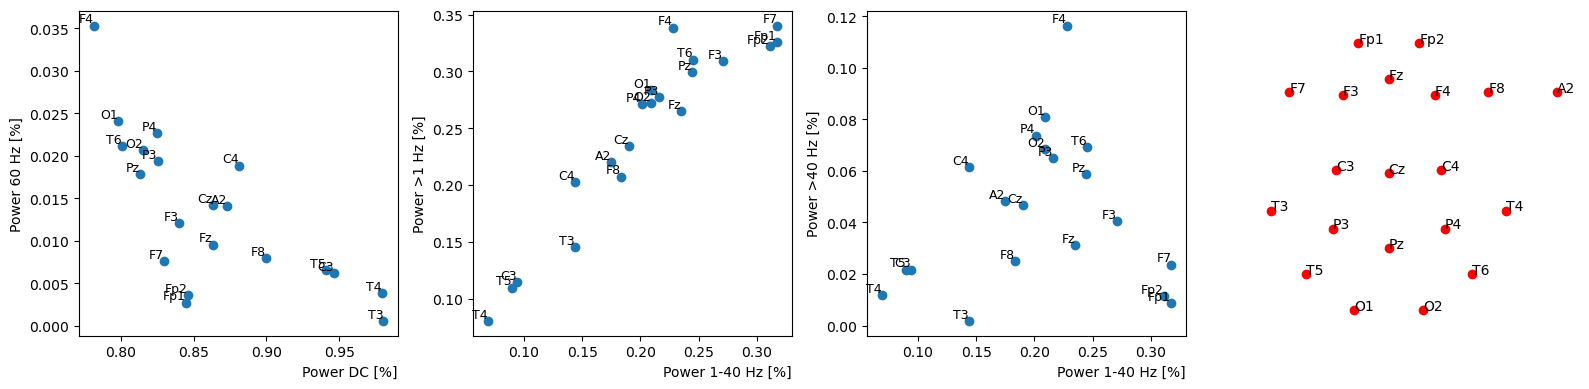

In [709]:
fig, axs = plt.subplots(1,4, figsize=(16,4))

axs[0].scatter(PfDC/PfAll, PfLine/PfAll)
for i, (x_i, y_i) in enumerate(zip(PfDC/PfAll, PfLine/PfAll)):
    axs[0].text(x_i, y_i, f'{ch_set.get_labels()[i]}', fontsize=9, ha='right', va='bottom')
axs[0].set_xlabel(r'Power DC [%]', loc='right')
axs[0].set_ylabel(r'Power 60 Hz [%]')

axs[1].scatter(PfInterest/PfAll, PfLow/PfAll)
for i, (x_i, y_i) in enumerate(zip(PfInterest/PfAll, PfLow/PfAll)):
    axs[1].text(x_i, y_i, f'{ch_set.get_labels()[i]}', fontsize=9, ha='right', va='bottom')
axs[1].set_xlabel(r'Power 1-40 Hz [%]', loc='right')
axs[1].set_ylabel(r'Power >1 Hz [%]')

axs[2].scatter(PfInterest/PfAll, PfHigh/PfAll)
for i, (x_i, y_i) in enumerate(zip(PfInterest/PfAll, PfHigh/PfAll)):
    axs[2].text(x_i, y_i, f'{ch_set.get_labels()[i]}', fontsize=9, ha='right', va='bottom')
axs[2].set_xlabel(r'Power 1-40 Hz [%]', loc='right')
axs[2].set_ylabel(r'Power >40 Hz [%]')

# Need to pass same colors
MI.show_electrode(eeg_dict.ch_location, ch_set.get_labels(), label=True, ax=axs[3], alpha_back=0)
axs[3].set_xlim(-1,1.5)
axs[3].set_ylim(-1,1)
axs[3].set_yticks([])
axs[3].set_xticks([])
axs[3].axis('off')

plt.tight_layout()
plt.show()

In [326]:
def categorize_electrodes(ch_location):
    frontal = []
    parietal_left = []
    parietal_right = []
    occipital = []
    central = []

    for electrode in ch_location:
        name, x, y = electrode
        if y > 0.5:  # Frontal area has higher y values in this setup
            frontal.append(name)
        elif y <= -0.1:  # Occipital area has lower y values
            occipital.append(name)
        elif -0.1 < y <= 0.5:  # Central region is roughly in the middle
            central.append(name)
            if x < 0:  # Left hemisphere
                parietal_left.append(name)
            elif x > 0:  # Right hemisphere
                parietal_right.append(name)

    return frontal, parietal_left, parietal_right, occipital, central

# Using the provided list of channels and their locations
ch_location = eeg_dict.ch_location

# Categorize the electrodes
frontal, parietal_left, parietal_right, occipital, central = categorize_electrodes(ch_location)

# Printing the results
print("Frontal:", frontal)
print("Parietal Left:", parietal_left)
print("Parietal Right:", parietal_right)
print("Occipital:", occipital)
print("Central:", central)

Frontal: ['F10', 'AF8', 'AF4', 'F2', 'E8', 'Fp2', 'E10', 'Fz', 'E14', 'FPz', 'AFz', 'E17', 'E18', 'F1', 'E21', 'Fp1', 'AF3', 'E25', 'AF7', 'F9', 'FT9', 'FT10', 'E125', 'E126', 'E127', 'E128']
Parietal Left: ['E7', 'E12', 'FC1', 'E20', 'F3', 'F5', 'FC5', 'FC3', 'C1', 'E31', 'F7', 'FT7', 'E35', 'C3', 'E39', 'E40', 'T7', 'C5', 'E43', 'T9', 'E48', 'A1', 'E49']
Parietal Right: ['E5', 'E80', 'C6', 'C4', 'C2', 'E106', 'E109', 'T8', 'E110', 'FC4', 'FC2', 'E113', 'T10', 'E115', 'FT8', 'FC6', 'E118', 'E119', 'A2', 'E120', 'F8', 'F6', 'F4']
Occipital: ['CP1', 'CP3', 'T3', 'TP7', 'CP5', 'E50', 'P5', 'P3', 'E53', 'E54', 'CPz', 'E56', 'TP9', 'E57', 'LM', 'T5', 'E59', 'P7', 'P1', 'E61', 'Pz', 'E63', 'P9', 'PO7', 'E66', 'PO3', 'E68', 'E69', 'O1', 'E71', 'POz', 'E73', 'E74', 'Oz', 'E76', 'PO4', 'E78', 'E79', 'E81', 'E82', 'O2', 'E84', 'P2', 'E86', 'CP2', 'E88', 'E89', 'PO8', 'E91', 'P8', 'P4', 'CP4', 'E94', 'P10', 'T6', 'P6', 'CP6', 'E99', 'TP10', 'E100', 'RM', 'E101', 'TP8', 'E107', 'T4', 'COM']
Centr

In [342]:
frontal = ['F10', 'AF8', 'AF4', 'F2', 'E8', 'Fp2', 'E10', 'Fz', 
           'E14', 'FPz', 'AFz', 'E17', 'E18', 'F1', 'E21', 'Fp1', 
           'AF3', 'E25', 'AF7', 'F9', 'E125', 'E126', 'E127', 'E128']

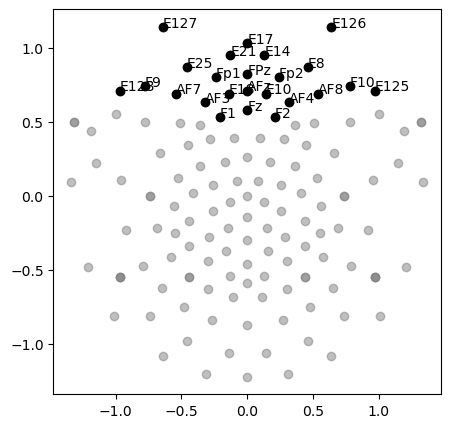

In [343]:
plt.figure(figsize=(5,5))
MI.show_electrode(eeg_dict.ch_location, frontal, color='black', label=True)

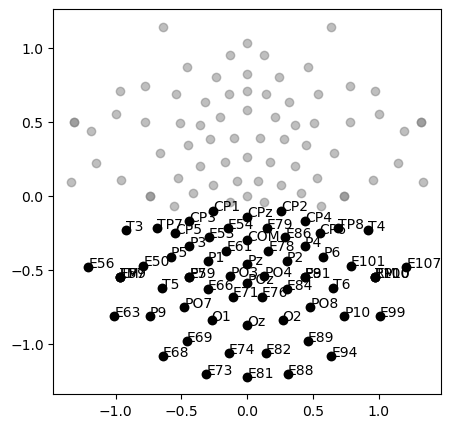

In [344]:
plt.figure(figsize=(5,5))
MI.show_electrode(eeg_dict.ch_location, occipital, color='black', label=True)

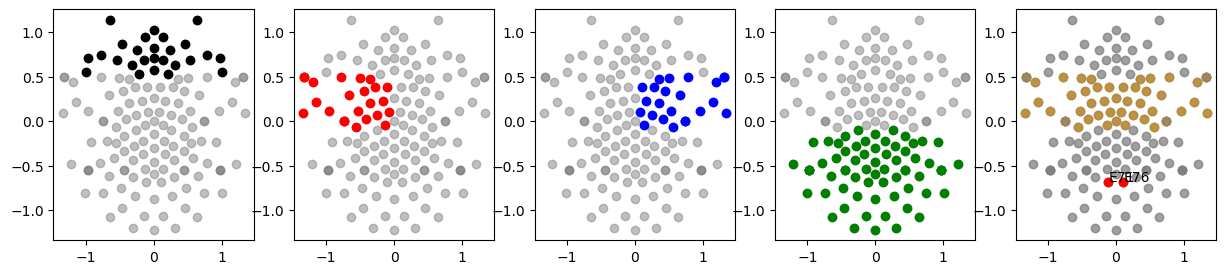

In [335]:
plt.figure(figsize=(5,5))
plt.subplot(151)
MI.show_electrode(eeg_dict.ch_location, frontal, color='black')
plt.subplot(152)
MI.show_electrode(eeg_dict.ch_location, parietal_left, color='red')
plt.subplot(153)
MI.show_electrode(eeg_dict.ch_location, parietal_right, color='blue')
plt.subplot(154)
MI.show_electrode(eeg_dict.ch_location, occipital, color='green')
plt.subplot(155)
MI.show_electrode(eeg_dict.ch_location, central, color='orange')
plt.subplot(155)
MI.show_electrode(eeg_dict.ch_location, ['E71','E76'], color='red', label=True)

### Bridged channels

In [724]:
def L1(x1=None, x2=None):
    # Manhattan
    return np.sum(np.abs(x1 - x2))

def L2(x1=None, x2=None):
    # Euclidean
    return np.sqrt(np.sum((x1 - x2) ** 2))

def Lp(x1=None, x2=None, p=4):
    # Minkovski (generalizes Euclidean)
    return np.sum(np.abs(x1 - x2) ** p) ** (1/p)

def Linf(x1=None, x2=None):
    # Chebishev
    return np.max(np.abs(x1 - x2))

def distance_matrix(x=None, distance=L2):
    n = x.shape[0]
    d = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j >= i: d[i,j] = distance(x[i], x[j])
            else: d[i,j] = d[j,i]
    return d

def gaussian(x=None, sigma=None):
    return np.exp(-x**2 / (2 * sigma**2)) / (sigma * np.sqrt(2*np.pi))

def gauss_affinity(d=None, sigma=None, neg=False):
    n = d.shape[0]
    a = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            a[i,j] = gaussian(d[i,j], sigma)
        
    for i in range(n):
        a[i,:] /= np.sum(a[i,:])
            
    if neg: 
        for i in range(n): 
            a[i,i] = 0
    return a

def find_min_row(d=None):
    n = d.shape[0]
    mins = []
    for i in range(n): 
        mins.append(np.min( d[i][d[i]>0] ))
    return np.array([mins]).ravel()

def map_channel(d=None, ch_set=None, ch='Cz', RAW=None, vlim=None, ax=None):
    ch_id = ch_set.find_labels(ch)
    im, cm = mne.viz.plot_topomap(d[ch_id].ravel(), RAW.info, ch_type='eeg', sensors=True, 
                                  cmap='Reds', show=False,
                                  names=ch_set.get_labels(), 
                                  vlim=vlim, 
                                  image_interp='nearest', contours=0,
                                  axes=ax)

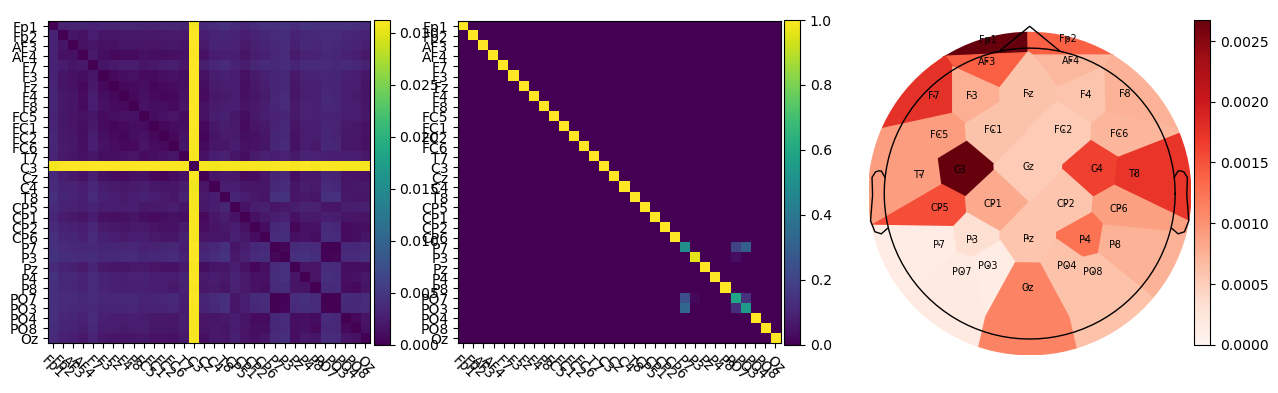

In [725]:
# Compute the Euclidean distance for each feature

last_sec = 30
x = MI.filter_data(signal=signal, fs=fs, l_freq=1, h_freq=40)[ :, int(-last_sec*fs): ] * 1e-6 #uV

distances = distance_matrix(x, distance=L2)
min_d = np.min( np.triu(distances, k=0)[np.triu(distances, k=0)>0] )
affinity = gauss_affinity(d=distances, sigma=min_d)
mins = find_min_row(distances)

x_labels = ch_set.get_labels()


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
cax = ax1.imshow(distances)
fig.colorbar(cax, ax=ax1, fraction=0.0475, pad=0.01)
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_xticklabels(x_labels, rotation=-45)
ax1.set_yticks(np.arange(len(x_labels)))
ax1.set_yticklabels(x_labels, rotation=0)

cax = ax2.imshow(affinity)
fig.colorbar(cax, ax=ax2, fraction=0.0475, pad=0.01)
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_xticklabels(x_labels, rotation=-45)
ax2.set_yticks(np.arange(len(x_labels)))
ax2.set_yticklabels(x_labels, rotation=0)

im, cm = mne.viz.plot_topomap(mins, RAW.info, ch_type='eeg', sensors=True, cmap='Reds', 
                              show=False, axes=ax3, 
                              names=ch_set.get_labels(), 
                              vlim=(0,min_d*20), 
                              image_interp='nearest', contours=0)
fig.colorbar(im, ax=ax3, fraction=0.0475, pad=0.01)
plt.show()

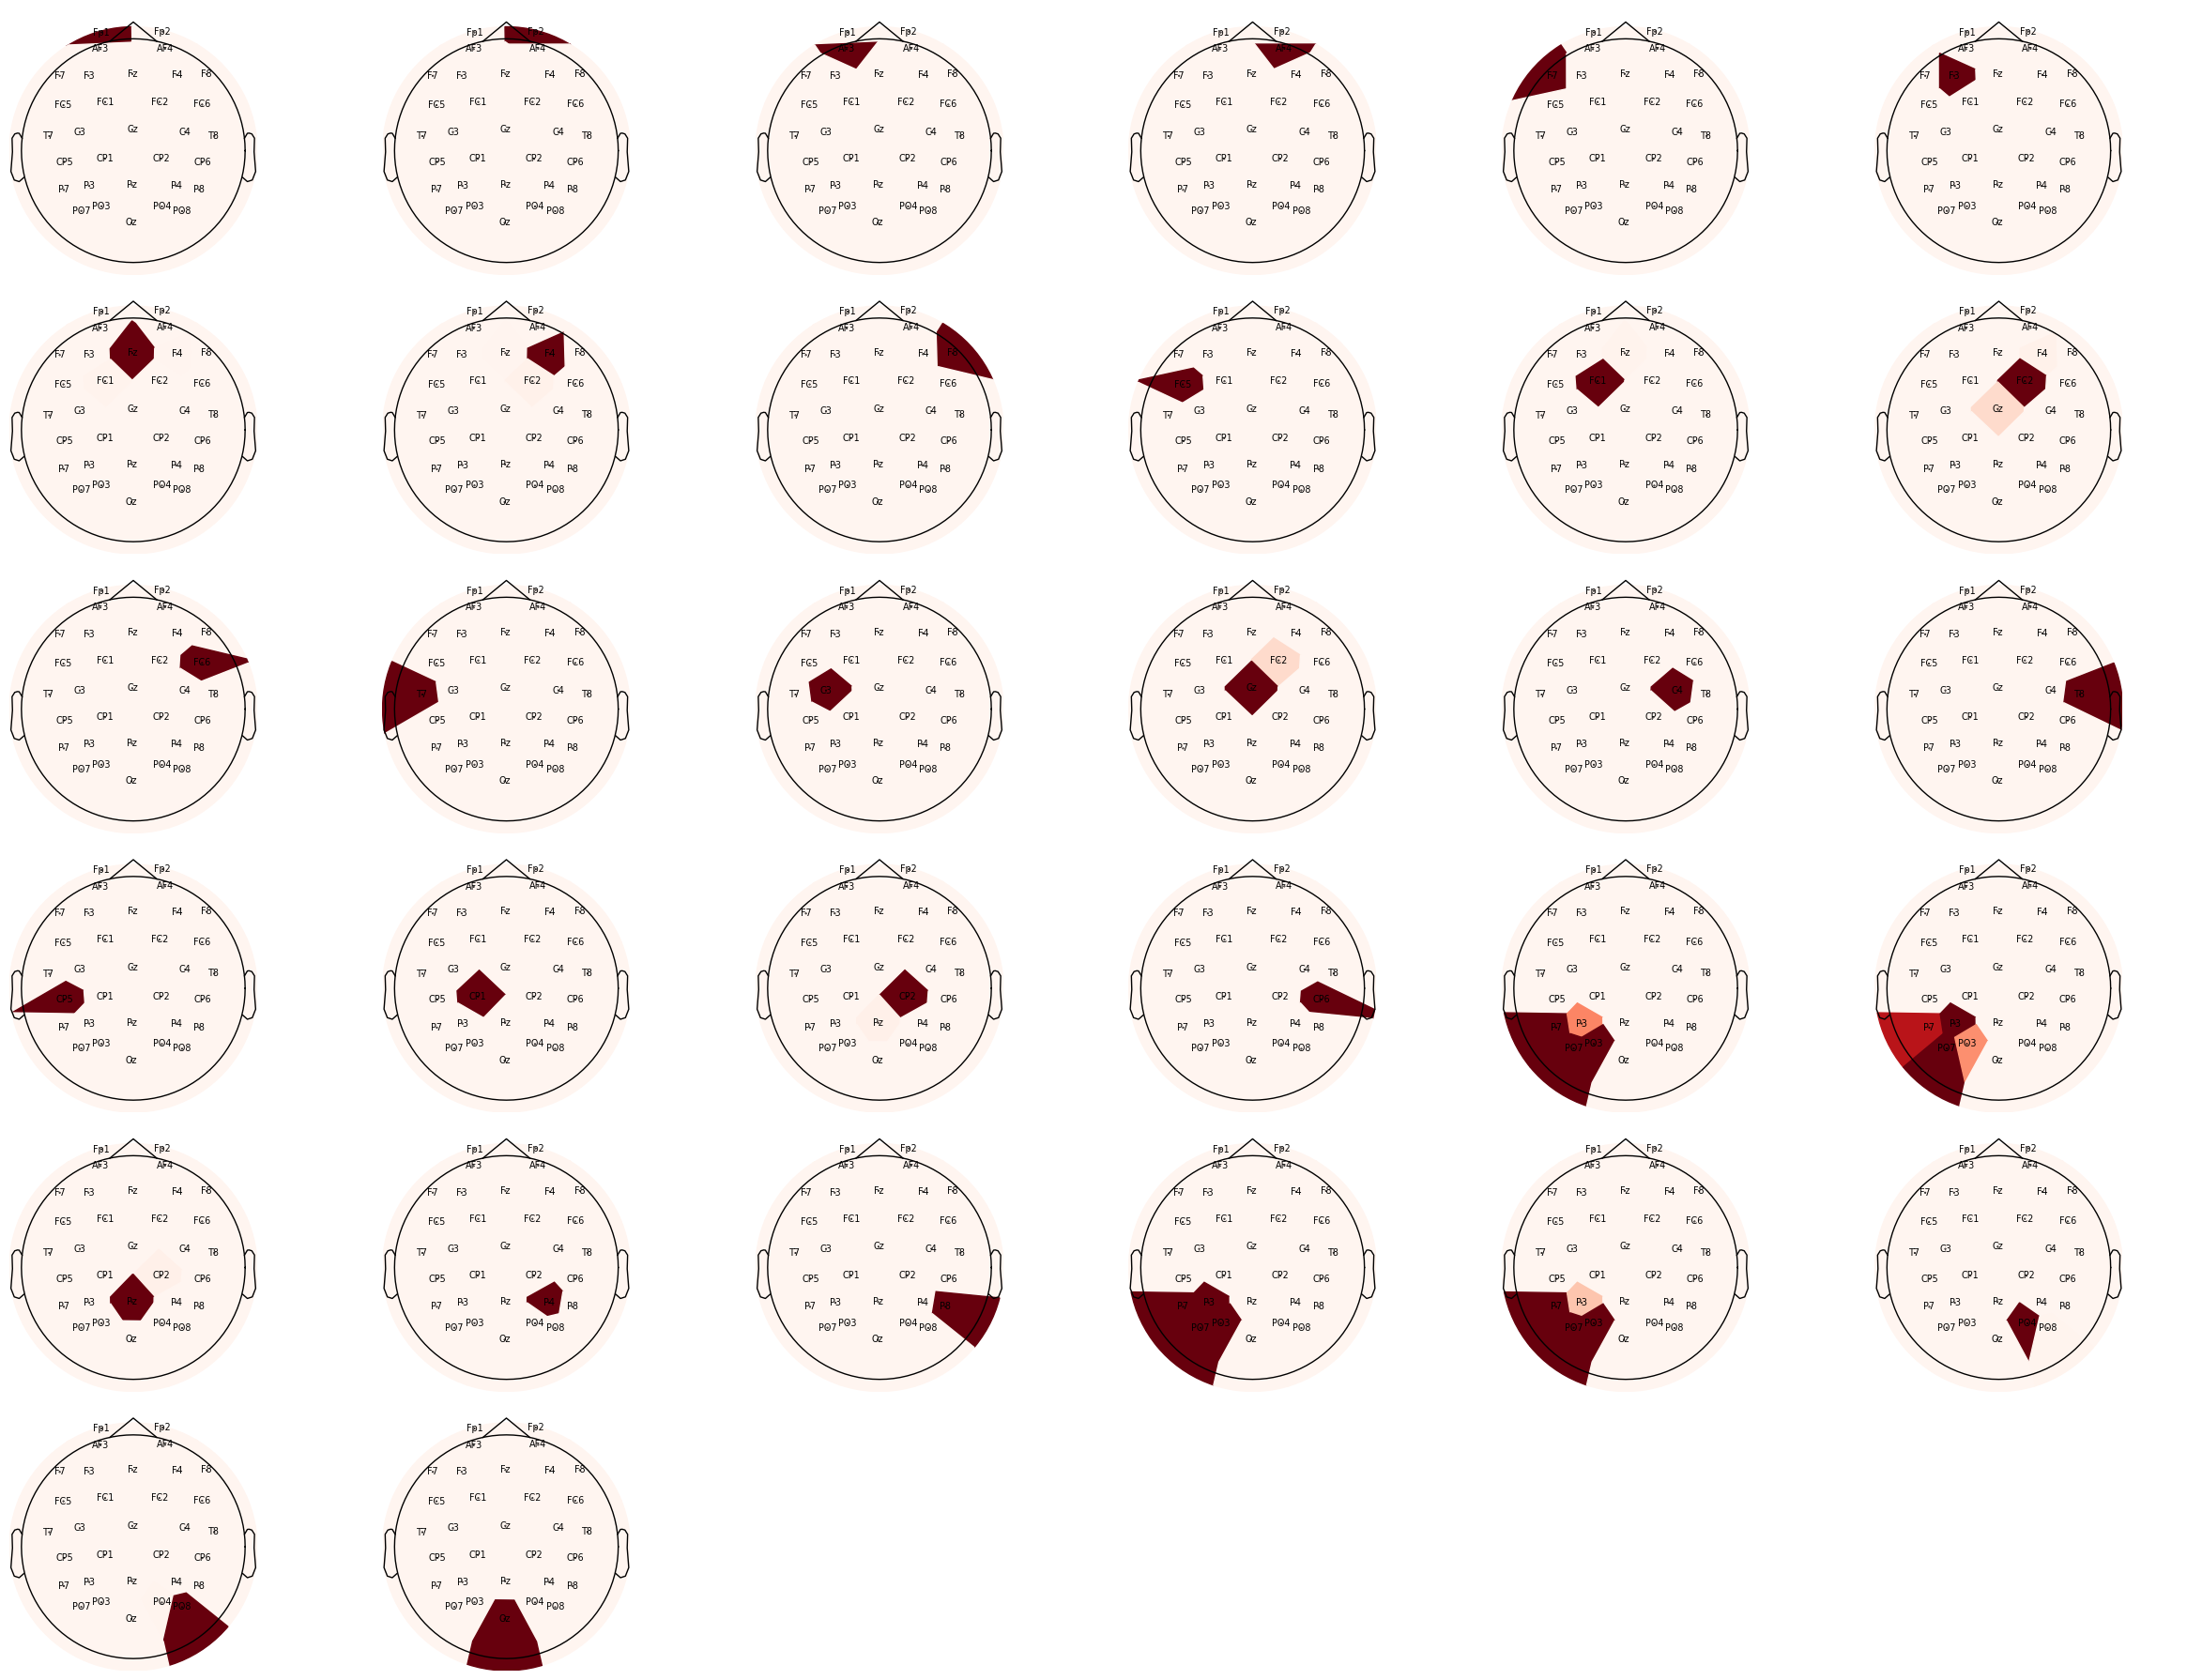

In [726]:
N = len(ch_set.get_labels())
if N>40: N=40
nrow = 5
ncol = N // nrow
if N % nrow != 0: nrow += 1

fig, axs = plt.subplots(nrow, ncol, figsize=(nrow*4, ncol*3))
# Iterate over each subplot to add a simple plot or customization
for i in range(nrow):
    for j in range(ncol):
        idx = int(i*ncol+j)
        if idx >= N: 
            axs[i, j].set_yticks([])
            axs[i, j].set_xticks([])
            axs[i, j].axis('off')
        else: 
            map_channel(d=affinity, ch_set=ch_set, ch=ch_set.get_labels()[idx], RAW=RAW, vlim=(0,min_d*20), ax=axs[i, j])
plt.tight_layout()
plt.show()

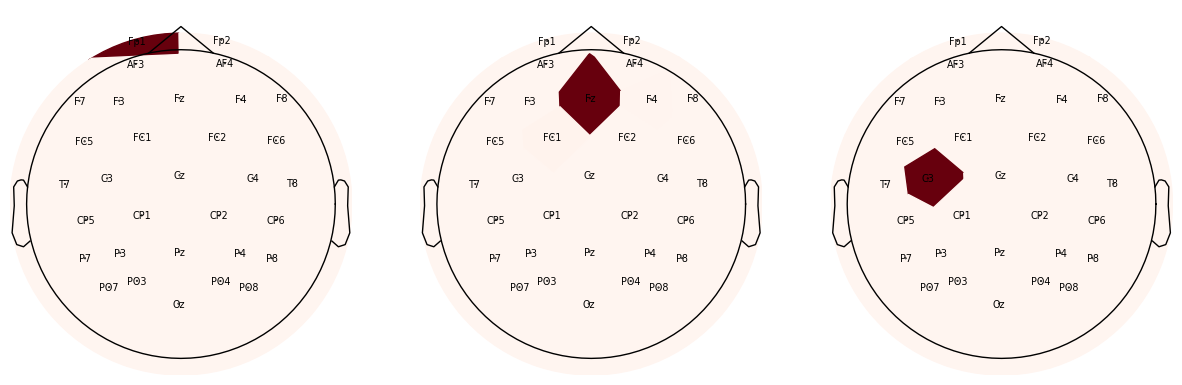

In [728]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
map_channel(d=affinity, ch_set=ch_set, ch='Fp1', RAW=RAW, vlim=(0, min_d*20), ax=axs[0])
map_channel(d=affinity, ch_set=ch_set, ch='Fz', RAW=RAW, vlim=(0, min_d*20), ax=axs[1])
map_channel(d=affinity, ch_set=ch_set, ch='C3', RAW=RAW, vlim=(0, min_d*20), ax=axs[2])

In [98]:
# Identify Left vs Right electrodes based on montage
isLeft_ch = [x for x in MI.find_ch_circle(ch_location, radius=0.74) if x in MI.find_ch_left(ch_location)]
isRight_ch = [x for x in MI.find_ch_circle(ch_location, radius=0.74) if x in MI.find_ch_right(ch_location)]

isLeft = np.array([True if x in isLeft_ch else False for x in ch_set.get_labels()])
isRight = np.array([True if x in isRight_ch else False for x in ch_set.get_labels()])

isLeft = np.array([True for x in ch_set.get_labels()])

In [99]:
def value_to_color(value, min_value, max_value, colormap='cool'):
    """
    Converts a numerical value to a color using a Matplotlib colormap.
    
    Args:
        value (float): The numerical value to convert to a color.
        min_value (float): The minimum value in the range of data; corresponds to the start of the colormap.
        max_value (float): The maximum value in the range of data; corresponds to the end of the colormap.
        colormap (str): The name of the Matplotlib colormap to use.
        
    Returns:
        A color (as an RGBA tuple) corresponding to the input value within the specified colormap.
    """
    # Normalize the value to a range between 0 and 1
    normalized_value = (value - min_value) / (max_value - min_value)
    
    # Clamp the value to be between 0 and 1
    normalized_value = min(max(normalized_value, 0), 1)
    
    # Get the colormap
    cmap = plt.get_cmap(colormap)
    
    # Get the color corresponding to the normalized value
    color = cmap(normalized_value)
    
    return color

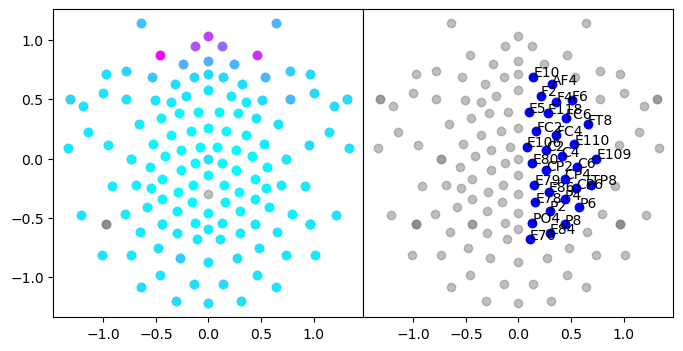

In [105]:
fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
left_labels = [x for x, y in zip(ch_set.get_labels(), isLeft) if y == True]
MI.show_electrode(ch_location, left_labels, False, [value_to_color(x, np.min(PfLow), np.max(PfLow)) for x in PfLow])
plt.subplot(122)
right_labels = [x for x, y in zip(ch_set.get_labels(), isRight) if y == True]
MI.show_electrode(ch_location, right_labels, True, 'blue')
plt.yticks([])
plt.subplots_adjust(wspace=0)  # Remove space between plots
plt.show()

### Signal values

In [715]:
def quality_segment(x=None):
    if x.shape[1]:
        # Signal has dim = (ch, t)
        mean = np.mean(x, axis=1)
        median = np.median(x, axis=1)
        rms = np.sqrt(np.mean(x**2, axis=1))
        xrange = np.max(x, axis=1).ravel() - np.min(x, axis=1)
        std = np.std(x, axis=1)
    else: 
        # Signal dim = (t,)
        mean = np.mean(x, axis=0)
        median = np.median(x, axis=0)
        rms = np.sqrt(np.mean(x**2, axis=0))
        xrange = np.max(x, axis=0).ravel() - np.min(x, axis=1)
        std = np.std(x, axis=0)
    return mean, median, rms, xrange, std

def quality_file(x=None, nPoints=None):
    if x.shape[1]:
        # Signal has dim = (ch, t)
        nCh = x.shape[0]
        nT = x.shape[1]
    else:
        # Signal has dim = (t,)
        nCh = 1
        nT = x.shape[0]
    nWindows = nT // nPoints
    if nT % nPoints == 0: pass
    else: nWindows += 1
    
    mean = np.zeros((nCh, nWindows))
    median = np.zeros((nCh, nWindows))
    rms = np.zeros((nCh, nWindows))
    xrange = np.zeros((nCh, nWindows))
    std = np.zeros((nCh, nWindows))
    
    for i in range(nWindows):
        # Extract the current window of data
        if nCh > 1: 
            data = x[:, i*nPoints : (i+1)*nPoints ]
        else: 
            data = x[ i*nPoints : (i+1)*nPoints ]
        # Calculate the mean and standard deviation of the current window
        mean[:,i], median[:,i], rms[:,i], xrange[:,i], std[:,i] = quality_segment(data)

    return mean, median, rms, xrange, std
    
def find_iqr(data=None):
    # Calculate Q1, Q3 and IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    Q2 = (Q3 + Q1)/2
    return Q2, IQR
    
def find_outliers_iqr(data=None, Q2=None, IQR=None, N=5):
    """
    Identifies the indices of outliers in a NumPy array based on the IQR method.
    
    Parameters:
    - data: A NumPy array containing the data
    
    Returns:
    - An array of indices corresponding to outliers in the input data.
    """
    if not Q2: 
        # Calculate Q1, Q3 and IQR
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        Q2 = (Q3 + Q1)/2

    # Calculate the outlier thresholds
    lower_bound = Q2 - N * IQR
    upper_bound = Q2 + N * IQR
    # Identify the indices of outliers
    outlier_indices = np.where((data < lower_bound) | (data > upper_bound))
    return outlier_indices[0]

In [716]:
tSec = 0.15
nPoints = int(tSec * fs)
mean, median, rms, xrange, std = quality_file(MI.filter_data(signal, fs, 1, 40) * 1e-6, nPoints)

In [717]:
Q2, IQR = find_iqr(rms)

In [718]:
outlier_indices = []
for ch in range(rms.shape[0]):
    data = rms[ch]
    outlier_indices.append(find_outliers_iqr(data, Q2, IQR, N=11))
outlier_indices = np.array([item for sublist in outlier_indices for item in sublist])
outlier_indices = np.unique(outlier_indices)

In [719]:
onset = [x*tSec for x in outlier_indices]
duration = [tSec for x in onset]
description = ['BAD_test' for x in onset]

In [720]:
my_annot = mne.Annotations(onset=onset, duration=duration, description=description)
RAW.set_annotations(my_annot)

<RawArray | 20 x 125400 (418.0 s), ~19.2 MB, data loaded>

In [721]:
RAW.filter(1,40).plot()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 991 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
2024-03-26 13:46:40,774 - qdarkstyle - INFO - QSS file sucessfuly loaded.
2024-03-26 13:46:40,775 - qdarkstyle - INFO - Found version patches to be applied.
2024-03-26 13:46:40,776 - qdarkstyle - INFO - Found application patches to be applied.


Channels marked as bad:
none


In [670]:
MI.evaluate_BAD_region(RAW=RAW, label='BAD_test', max_duration=signal.shape[1]/fs)

 --> BAD_test: 224 sections, ~33.6 s [8.0%] --> Bad channels: []


### Blinks Detection

In [54]:
def moving_average(data, window_size):
    """
    Calculate the moving average of a given data set and window size, with padding.
    
    Args:
        data (list or numpy array): The sequence of data points.
        window_size (int): The number of data points to include in each average.
        
    Returns:
        numpy array: The moving average of the data with the same dimension as the input.
    """
    # Ensure data is a numpy array for efficient computation
    data = np.array(data)
    
    # Create a simple moving average (SMA) using convolution, with padding at the ends
    weights = np.ones(window_size) / window_size
    moving_avg = np.convolve(data, weights, mode='same')
    
    # To match the output size with input size and pad with zeros,
    # Adjust the moving average values at the beginning and the end
    pad_len = window_size // 2
    moving_avg[:pad_len] = 0
    moving_avg[-pad_len:] = 0
    
    return moving_avg

def detect_big_changes(derivative_array, threshold):
    """
    Detect positions in the derivative array where a big change has occurred.
    Parameters:
    - derivative_array: NumPy array, the first derivative array.
    - threshold: float, the threshold for considering a change as "big."
    Returns:
    - NumPy array, boolean array indicating positions of big changes.
    """
    # Determine positions where the absolute value of the derivative exceeds the threshold
    big_change_positions = np.abs(derivative_array) > threshold
    #big_change_positions[250:] = False
    return big_change_positions

def pad_array_around_changes(input_array, big_change_positions, padding_size):
    """
    Pad the input array with zeros around positions of big changes.
    Parameters:
    - input_array: NumPy array, the original input array.
    - big_change_positions: NumPy array, boolean array indicating positions of big changes.
    - padding_size: int, size of padding around big changes.
    Returns:
    - NumPy array, the input array padded with zeros around big changes.
    """
    padded_array = np.copy(input_array)
    for index in np.where(big_change_positions)[0]:
        start_index = max(0, index - padding_size)
        end_index = min(len(input_array), index + padding_size + 1)
        padded_array[start_index:end_index] = 0
    return padded_array

def windowed_z_score(data, window_size):
    """
    Apply a windowed z-scoring operation to a 1D array, using the actual remaining points for the last window if it's
    shorter than the specified window size. This involves calculating the mean and standard deviation for each window,
    then standardizing the points in the window.

    Args:
        data (numpy array): The 1D array of data points.
        window_size (int): The size of the window to apply the z-scoring within.

    Returns:
        numpy array: The array after applying windowed z-scoring.
    """
    # Ensure data is a numpy array for manipulation
    data = np.array(data)
    x_standardized = np.zeros(data.shape)
    
    windows = data.shape[0] // window_size
    if data.shape[0] % window_size == 0: pass
    elif data.shape[0] % window_size != 0: windows += 1
    
    for i in range(windows):
        # Extract the current window of data
        x = data[ i*window_size : (i+1)*window_size ]
        # Calculate the mean and standard deviation of the current window
        x_mean = np.mean(x)
        x_std = np.std(x)
        
        # Standardize the point at the current index
        # Avoid division by zero by checking if window_std is not zero
        if x_std != 0:
            x_standardized[ i*window_size : (i+1)*window_size ] = [(y-x_mean)/x_std for y in x]
        else:
            # If standard deviation is zero, it means all values in the window are the same
            # The standardized value in this case can be set to 0 (since data[i] = window_mean)
            x_standardized[ i*window_size : (i+1)*window_size ] = [0]*window_size
    return x_standardized

In [83]:
signalFilter = MI.filter_data(signal, fs, 1, 1.5)

In [84]:
ch_per5 = np.percentile(signalFilter[ch_set.find_labels('Fp1')].ravel(), 5)
ch_per95 = np.percentile(signalFilter[ch_set.find_labels('Fp1')].ravel(), 95)
ch_mean = np.mean(signalFilter[ch_set.find_labels('Fp1')].ravel())
ch_median = np.median(signalFilter[ch_set.find_labels('Fp1')].ravel())
ch_per90 = np.percentile(signalFilter[ch_set.find_labels('Fp1')].ravel(), 90)
ch_per99 = np.percentile(signalFilter[ch_set.find_labels('Fp1')].ravel(), 99)

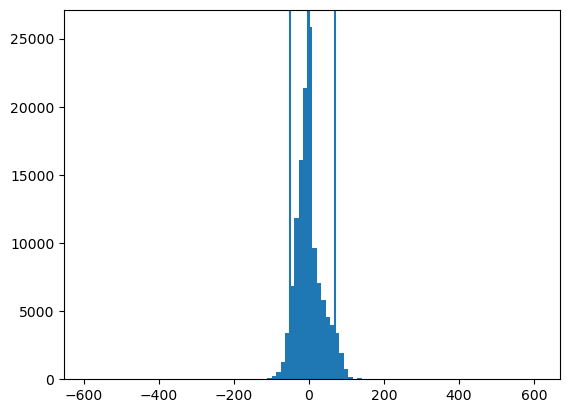

In [85]:
plt.hist(signalFilter[ch_set.find_labels('Fp1')].ravel(), bins=100)
plt.axvline(ch_per5)
plt.axvline(ch_per95)
plt.axvline(ch_mean)
plt.axvline(ch_median)

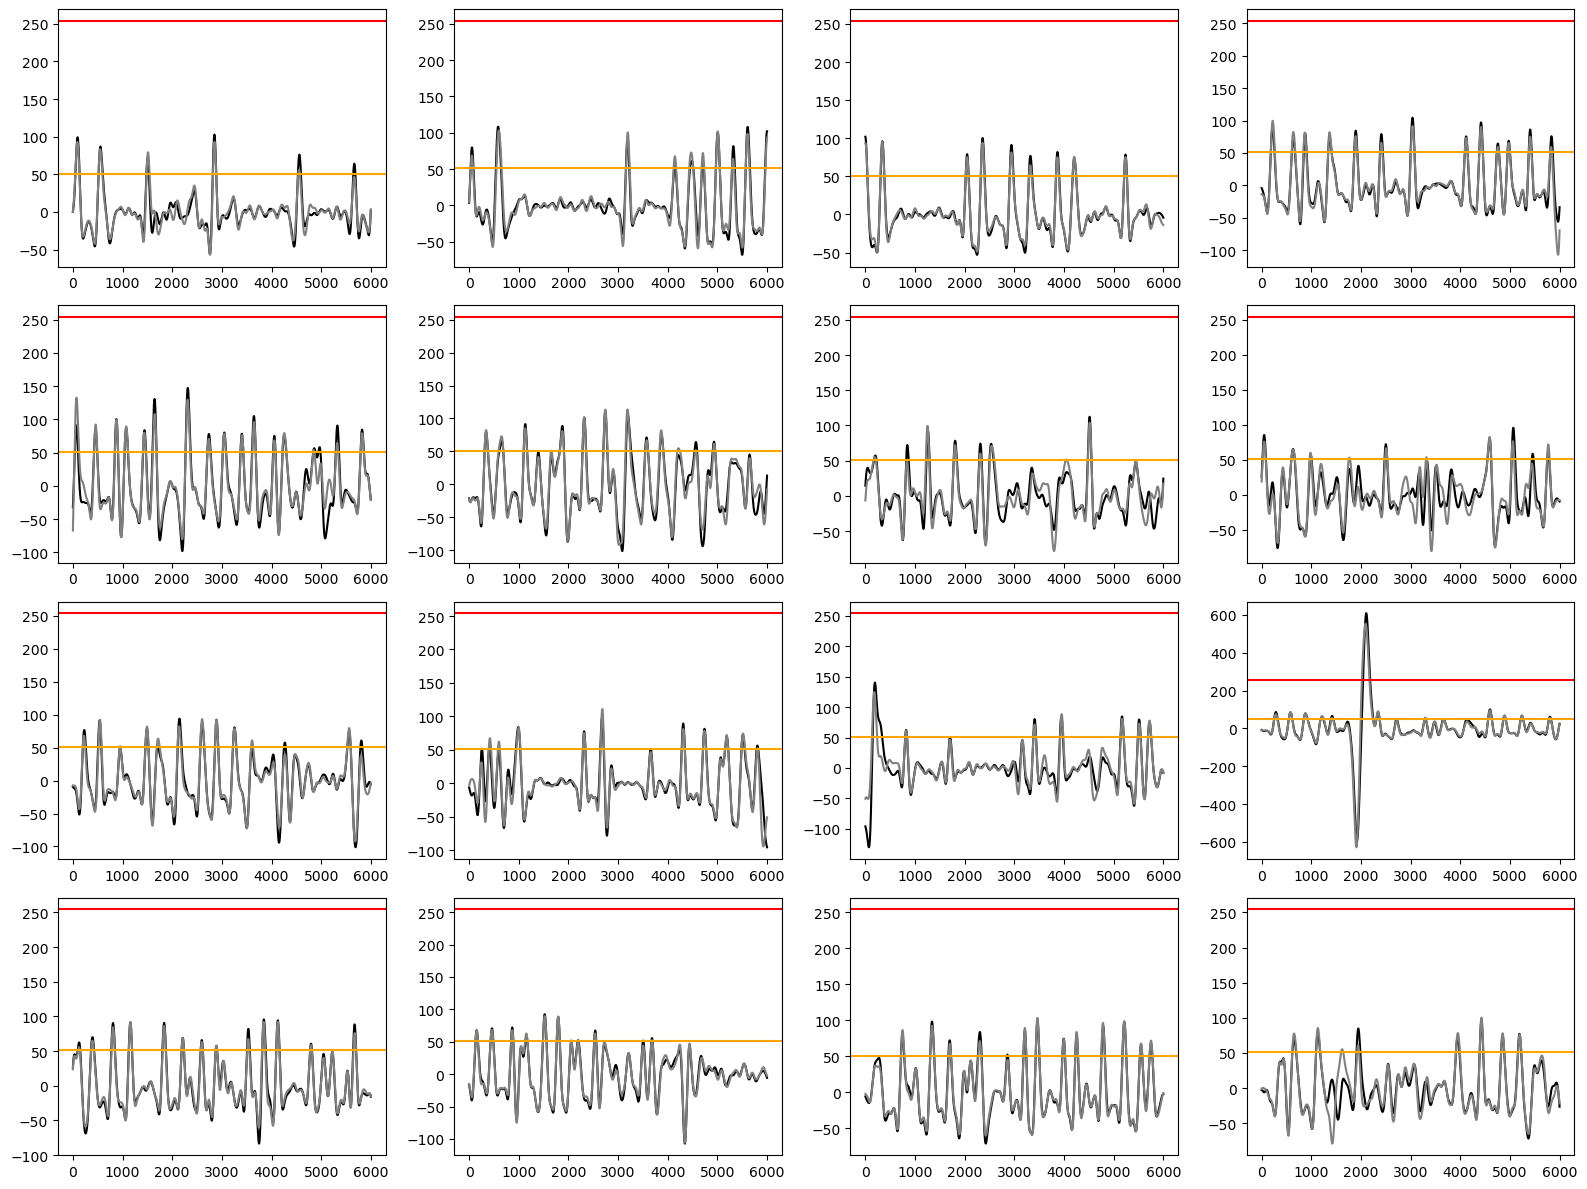

In [86]:
fileTime = signal.shape[1] // fs
N = 20
nrow_ncol = fileTime // N
nrow = int(np.sqrt(nrow_ncol))
ncol = int(np.sqrt(nrow_ncol))
fig, axs = plt.subplots(nrow, ncol, figsize=(nrow*4, ncol*3))
# Iterate over each subplot to add a simple plot or customization
for i in range(nrow):
    for j in range(ncol):
        x = signalFilter[ch_set.find_labels('Fp1')].ravel()[ (i*ncol+j)*int(fs * N) : (i*ncol+j+1)*int(fs * N) ]
        y = signalFilter[ch_set.find_labels('Fp2')].ravel()[ (i*ncol+j)*int(fs * N) : (i*ncol+j+1)*int(fs * N) ]
        t = np.arange(x.shape[0])
        x_prime = np.gradient(x, axis=0)
        #x_second = np.gradient(x_prime, axis=0)
        #x_third = np.gradient(x_second, axis=0)
        zscore = windowed_z_score(x, window_size=int(fs * 5))* 10
        axs[i, j].plot(x,          color='black')
        axs[i, j].plot(y,          color='grey')
        #axs[i, j].plot((zscore / np.max(zscore)), color='blue')
        axs[i, j].axhline(ch_per90, color='orange')
        axs[i, j].axhline(ch_per90*5, color='red')
        #axs[i, j].set_ylim(-1,1)
plt.tight_layout()
plt.show()

In [ ]:
#plt.plot(x_prime*50)
plt.plot(MI.filter_data(x, fs, 1, 2))
big_change_positions = detect_big_changes(MI.filter_data(x_prime, fs, 1, 2)*50, np.max(MI.filter_data(x_prime, fs, 1, 2)*50)*0.5)
big_change_positions = detect_big_changes(x, np.max(x)*0.5)
plt.plot(pad_array_around_changes(x, big_change_positions, int(0.3 / (1/fs))))

plt.plot(windowed_z_score(x, window_size=10000)*10)

#for i in t[big_change_positions]: 
#    plt.axvline(i)

#plt.plot(moving_average(x_prime, 100)*50)
#plt.plot(x_second)
#plt.plot(x_third)
#plt.ylim(-2,2)